In [1]:
# %%bash
!pip install tqdm

# # Move API key to where Kaggle expects it
# mv /home/ec2-user/SageMaker/SkinCancerCapstone/kaggle.json /home/ec2-user/.kaggle

# kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# unzip skin-cancer-mnist-ham10000.zip -d data

In [2]:
import numpy as np
import pandas as pd
import os, cv2, itertools
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [3]:
data_dir = os.path.join('..', 'data')
data_dir = 'data'
all_image_path = glob(os.path.join(data_dir, '*','*.jpg'))

# building dictionary of image id as key and file path as value
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    
    means_np = np.array(means)
    np.savez('means', means_np)
    
    stdevs_np = np.array(stdevs)
    np.savez('stdevs', stdevs_np)
    
    
    return means,stdevs

means, stdevs = compute_img_mean_std(all_image_path)

 82%|██████████████████████████████████████████████████████████████▉              | 8192/10015 [02:14<00:34, 52.86it/s]

KeyboardInterrupt: 

In [4]:
# Building dictionary for lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
#  Open the csv file
filepath = os.path.join(data_dir, 'HAM10000_metadata.csv')
df = pd.read_csv(filepath)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# Will need for model building
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
7519,HAM_0003512,ISIC_0033155,nv,histo,35.0,male,back,data\HAM10000_images_part_2\ISIC_0033155.jpg,Melanocytic nevi,4
8773,HAM_0006094,ISIC_0026998,nv,histo,40.0,female,genital,data\HAM10000_images_part_1\ISIC_0026998.jpg,Melanocytic nevi,4
3831,HAM_0003114,ISIC_0032091,nv,follow_up,45.0,female,back,data\HAM10000_images_part_2\ISIC_0032091.jpg,Melanocytic nevi,4
4526,HAM_0002524,ISIC_0026184,nv,follow_up,55.0,male,trunk,data\HAM10000_images_part_1\ISIC_0026184.jpg,Melanocytic nevi,4
1281,HAM_0007560,ISIC_0024987,mel,histo,75.0,male,unknown,data\HAM10000_images_part_1\ISIC_0024987.jpg,Melanoma,5


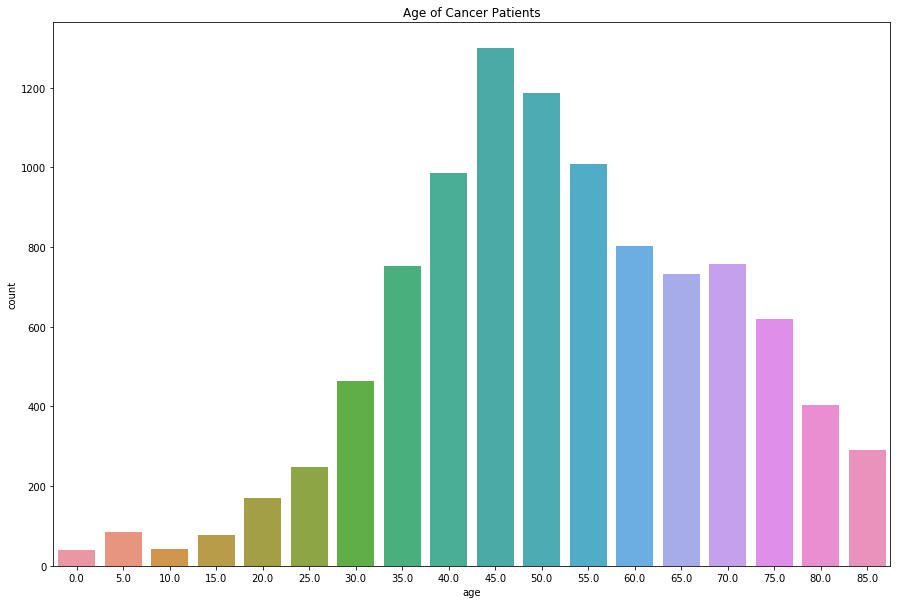

In [7]:
plt.figure(figsize = (15,10))
sns.countplot(df['age'])
plt.title('Age of Cancer Patients')
plt.show()

In [8]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [9]:
df['age'].fillna(int(df['age'].mean()), inplace = True)

In [10]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

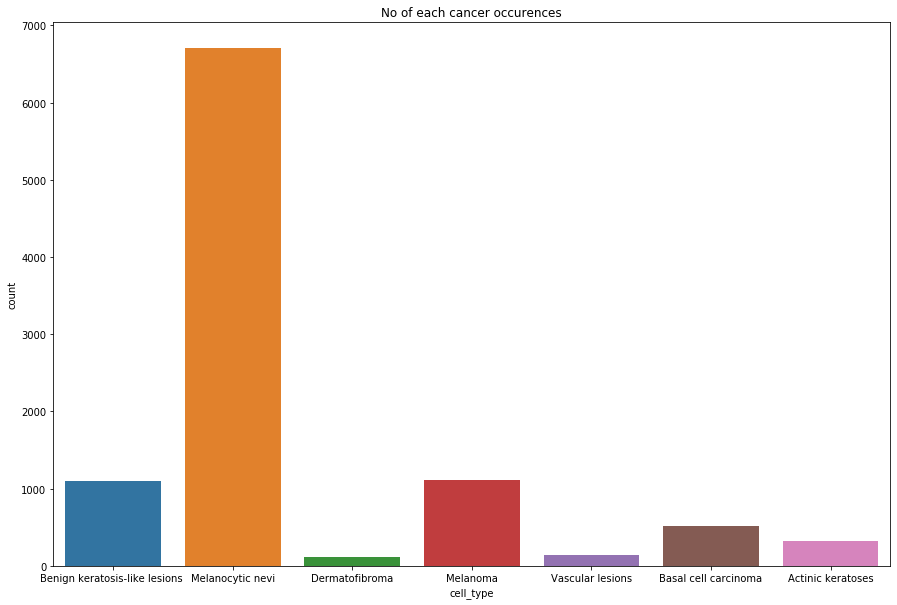

In [11]:
plt.figure(figsize = (15,10))
sns.countplot(df['cell_type'])
plt.title('No of each cancer occurences')
plt.show()

Text(0.5, 1.0, 'No of cancer occurences on body')

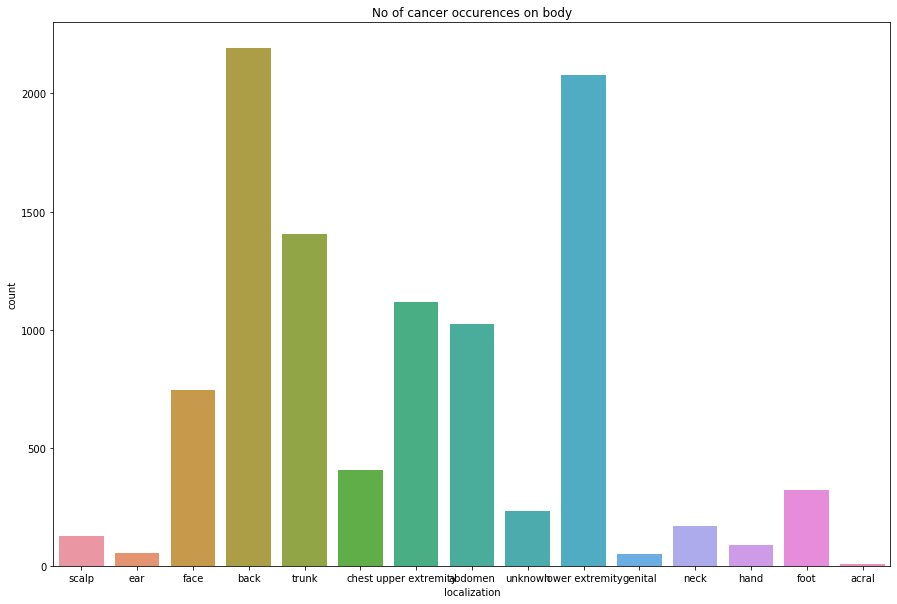

In [12]:
plt.figure(figsize = (15,10))
sns.countplot(df['localization'])
plt.title('No of cancer occurences on body')


Text(0.5, 1.0, 'No of cancer occurences acreoss gender')

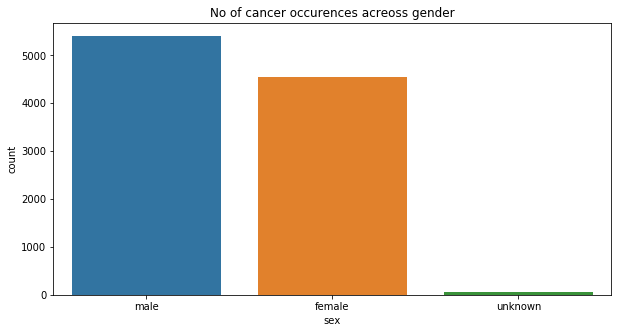

In [16]:
plt.figure(figsize = (10,5))
sns.countplot(df['sex'])
plt.title('No of cancer occurences acreoss gender')

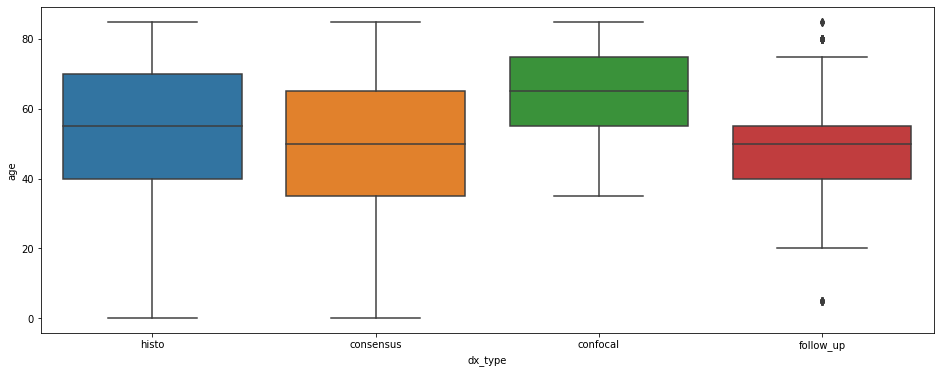

In [17]:
plt.figure(figsize=(16,6))
sns.boxplot(x='dx_type', y='age', data=df)

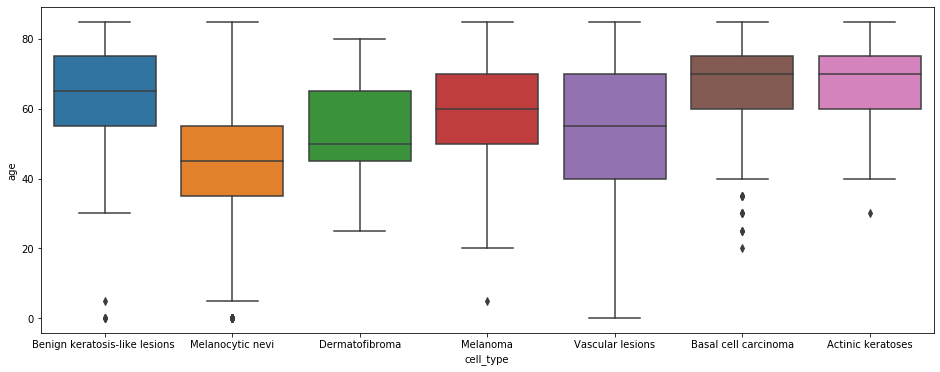

In [18]:
plt.figure(figsize=(16,6))
sns.boxplot(x='cell_type', y='age', data=df)

In [20]:
df_undup = df.groupby('lesion_id').count()

In [21]:
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [22]:
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(get_duplicates)
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
2733,HAM_0003866,ISIC_0025046,bcc,histo,65.0,female,abdomen,data\HAM10000_images_part_1\ISIC_0025046.jpg,Basal cell carcinoma,1,duplicated
1848,HAM_0005627,ISIC_0033568,mel,histo,45.0,male,back,data\HAM10000_images_part_2\ISIC_0033568.jpg,Melanoma,5,duplicated
6121,HAM_0003474,ISIC_0025212,nv,follow_up,40.0,male,trunk,data\HAM10000_images_part_1\ISIC_0025212.jpg,Melanocytic nevi,4,unduplicated
2184,HAM_0004507,ISIC_0024554,mel,histo,65.0,female,face,data\HAM10000_images_part_1\ISIC_0024554.jpg,Melanoma,5,duplicated
555,HAM_0001938,ISIC_0026245,bkl,histo,45.0,female,lower extremity,data\HAM10000_images_part_1\ISIC_0026245.jpg,Benign keratosis-like lesions,2,unduplicated


In [23]:
df['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [24]:
df.to_csv(os.path.join(data_dir,'updated_metadata.csv'))

In [25]:
data_dir = 'data'
df = pd.read_csv(os.path.join(data_dir, 'updated_metadata.csv'))
df.drop(df.columns[0], axis = 1, inplace = True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [26]:
df_undup = df[df['duplicates'] == 'unduplicated']
print(df_undup.shape)
print(df['duplicates'].value_counts())

(5514, 11)
unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64


The data is needed to be split into 3 parts training testing and validation
To create a Test and Validation dataset we need to create a dataframe of original images.

In [28]:
y = df_undup['cell_type_idx']
df_train, df_val = train_test_split(df_undup, test_size = 0.6, random_state = 101, stratify = y)
y = df_train['cell_type_idx']
# df_train, df_val = train_test_split(df_train, test_size = 0.31, random_state = 101, stratify = y)
# train_df = df[df['duplicates'] == 'duplicated']
# df_train = pd.concat([df[df['duplicates'] == 'duplicated'], df_train])
df_train = df[df['duplicates'] == 'duplicated'].append(df_train)
print(df_train.shape)
# print(df_test.shape)
print(df_val.shape)

(6706, 11)
(3309, 11)


In [6]:
df_val = pd.read_csv('data/validation.csv')
df_val['cell_type'].value_counts()

Melanocytic nevi                  2650
Benign keratosis-like lesions      264
Melanoma                           138
Basal cell carcinoma               105
Actinic keratoses                   91
Vascular lesions                    38
Dermatofibroma                      23
Name: cell_type, dtype: int64

Data is imbalanced, Which is needed to be balanced

In [40]:
# df['cell_type_idx'].value_counts(sort = False)
data_aug_rate = [17, 10, 5, 45, 0, 4, 39]

for i in range(7):
    if data_aug_rate[i]:
        df_train = df_train.append([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index = True)

print(df_train.shape)
df_train['cell_type_idx'].value_counts(sort = False)

(28428, 11)


0    4012
1    4090
2    4175
3    4140
4    4055
5    3900
6    4056
Name: cell_type_idx, dtype: int64

In [1]:
df_val['cell_type'].value_counts()

NameError: name 'df_val' is not defined

In [42]:
# df_test['cell_type_idx'].value_counts()

In [43]:
# df_train.reset_index()
# df_train.head()
# df_test.reset_index(drop = True, inplace = True)
# df_test.head()

# df_test.drop(df.columns[0], axis = 1, inplace = True)
df_val.reset_index(drop = True, inplace = True)
df_val.head()
# df_val.drop(df.columns[0], axis = 1, inplace = True)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0002787,ISIC_0025425,vasc,consensus,50.0,male,trunk,data\HAM10000_images_part_1\ISIC_0025425.jpg,Vascular lesions,6,unduplicated
1,HAM_0001233,ISIC_0029110,nv,follow_up,35.0,male,upper extremity,data\HAM10000_images_part_1\ISIC_0029110.jpg,Melanocytic nevi,4,unduplicated
2,HAM_0007336,ISIC_0024544,nv,follow_up,45.0,male,back,data\HAM10000_images_part_1\ISIC_0024544.jpg,Melanocytic nevi,4,unduplicated
3,HAM_0001277,ISIC_0031927,akiec,histo,75.0,male,chest,data\HAM10000_images_part_2\ISIC_0031927.jpg,Actinic keratoses,0,unduplicated
4,HAM_0000191,ISIC_0030206,nv,follow_up,30.0,male,lower extremity,data\HAM10000_images_part_2\ISIC_0030206.jpg,Melanocytic nevi,4,unduplicated


In [44]:
df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [45]:
df_train.to_csv(os.path.join(data_dir,'train.csv'))
# df_test.to_csv(os.path.join(data_dir,'test.csv'))
df_val.to_csv(os.path.join(data_dir,'validation.csv'))

In [46]:
import pandas as pd 

In [47]:
df = pd.read_csv('data/updated_metadata.csv')

In [50]:
df_val.shape

(3309, 11)

Now the data is in suitable format for the modelling.